In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import glob

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

2025-06-14 16:37:16.360949: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-14 16:37:16.553350: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749908236.644410   10342 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749908236.664691   10342 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749908236.801392   10342 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
# Creating list of csv files
allfiles = glob.glob('/home/mike-pi/Documents/coding/Fedya_ML/Data/unzipped_faraz/surfaceCSVs/*.csv')

In [3]:
# Creating empty data frane with the required columns
data = pd.DataFrame(columns=['x', 'y', 'force_x', 'force_y', 'sigma_x', 'sigma_y', 'tau_xy'])

In [4]:
# Concatenating all csv files into one
dfs = [] # Empty list to append newly read csv files
for file in allfiles:
    data = pd.DataFrame(columns=['x', 'y', 'force_x', 'force_y', 'sigma_x', 'sigma_y', 'tau_xy'])
    df = pd.read_csv(file, comment='#', delimiter=' ', header=None)
    data['x'] = df[0]
    data['y'] = df[1]
    data['force_x'] = int(file.split('/')[-1].split('-')[0])
    data['force_y'] = 0
    data['sigma_x'] = df[3]
    data['sigma_y'] = df[6]
    data['tau_xy'] = df[4]
    dfs.append(data)
result = pd.concat(dfs, ignore_index=True)

In [5]:
# Creating dataset 

# Features: Coordinates (x, y) and applied forces (force_x, force_y)
X = result[['x', 'y', 'force_x', 'force_y']].values

# Target: Stress components (sigma_x, sigma_y, tau_xy)
y = result[['sigma_x', 'sigma_y', 'tau_xy']].values

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
# scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train = scaler.fit_transform(y_train)
y_test = scaler.fit_transform(y_test)

In [6]:
def build_improved_model(input_shape):
    model = Sequential([
        Input(shape=(input_shape,)),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        BatchNormalization(),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(3)  # Output: 3 stress components
    ])
    
    # Custom learning rate schedule
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.001,
        decay_steps=10000,
        decay_rate=0.9)
    
    early_stop = EarlyStopping(monitor='val_loss', patience=50)

    model.compile(
        optimizer=Adam(learning_rate=lr_schedule),
        loss='mse',
        metrics=['accuracy']  
    )
    return model

# def build_model(input_shape):
#     model = Sequential([
#         Dense(128, activation='relu', input_shape=(input_shape,)),
#         BatchNormalization(),
#         Dropout(0.2),
#         Dense(64, activation='relu'),
#         Dense(32, activation='relu'),
#         Dense(3)  # Output: 3 stress components (sigma_x, sigma_y, tau_xy)
#     ])
#     model.compile(
#         optimizer=Adam(learning_rate=0.001),
#         loss='mse',  # Mean Squared Error for regression
#         metrics=['mae']
#     )
#     return model

model = build_improved_model(X_train.shape[1])
model.summary()

W0000 00:00:1749908239.481346   10342 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,147 (180.26 KB)

 Trainable params: 45,379 (177.26 KB)

 Non-trainable params: 768 (3.00 KB)

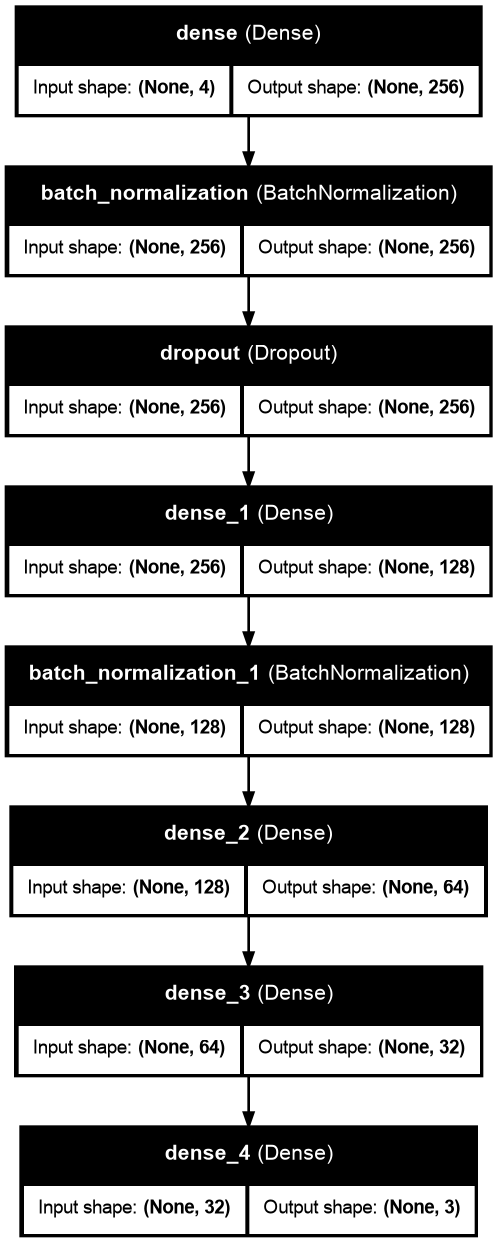

In [7]:
from keras.utils import plot_model

# Build your model
# model = ...  # Your Keras Sequential or Functional API model

# Generate and save the plot
plot_model(
    model,
    to_file='model_architecture.png',
    show_shapes=True,      # Displays input/output shapes
    show_layer_names=True, # Shows layer names
    rankdir='TB',          # 'TB' (Top-Bottom) or 'LR' (Left-Right)
    dpi=96                # Adjust image DPI
)

Epoch 1/30
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7823 - loss: 1.0340 - val_accuracy: 0.8997 - val_loss: 0.1155
Epoch 2/30
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8836 - loss: 0.1465 - val_accuracy: 0.9159 - val_loss: 0.0699
Epoch 3/30
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8950 - loss: 0.1143 - val_accuracy: 0.9180 - val_loss: 0.0661
Epoch 4/30
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8999 - loss: 0.1120 - val_accuracy: 0.9374 - val_loss: 0.0608
Epoch 5/30
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9070 - loss: 0.0987 - val_accuracy: 0.9403 - val_loss: 0.0582
Epoch 6/30
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9078 - loss: 0.0918 - val_accuracy: 0.9381 - val_loss: 0.0666
Epoch 7/30
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9109 - loss: 0.0879 - val_accuracy: 0.9218 - val_loss: 0.0617
Epoch 8/30
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9123 - loss: 0.0848 - 

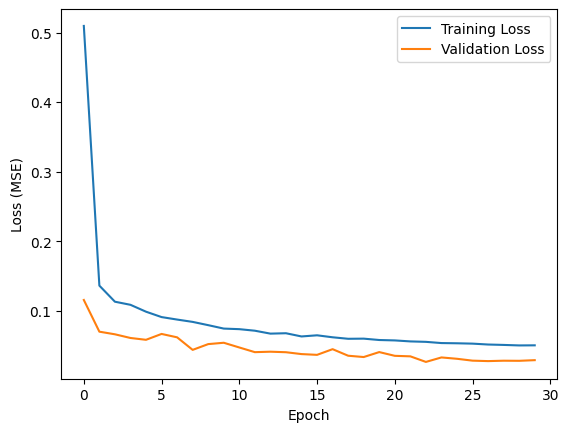

In [8]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

In [9]:
# Evaluate on test data
mse, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test acuracy: {accuracy}, Test MSE: {mse:.4f}")

# Predict stresses for test set
y_pred = model.predict(X_test)

Test acuracy: 0.9499884247779846, Test MSE: 0.0288
677/677 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step


In [10]:
# Descaling
# X_test = scaler.inverse_transform(X_test)
# y_test = scaler.inverse_transform(y_test)
# y_pred = scaler.inverse_transform(y_pred)

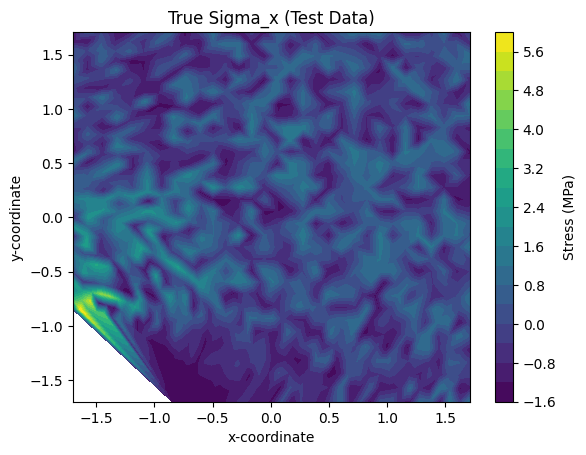

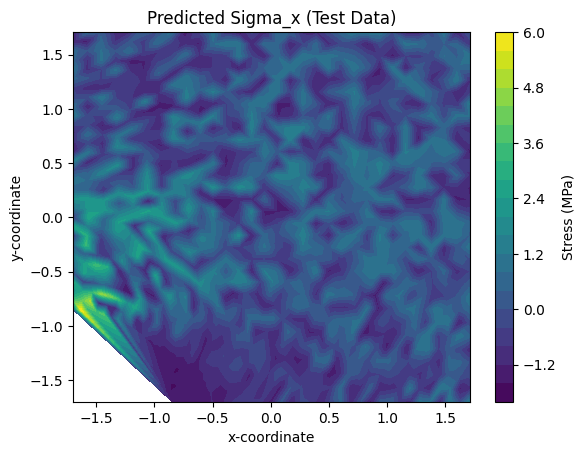

In [11]:
def plot_stress_contour(x, y, stress, title):
    plt.tricontourf(x, y, stress, levels=20, cmap='viridis')
    plt.colorbar(label='Stress (MPa)')
    plt.xlabel('x-coordinate')
    plt.ylabel('y-coordinate')
    plt.title(title)
    plt.show()

# Plot true vs. predicted sigma_x for the first test case
sample_idx = 0
plot_stress_contour(
    X_test[:, 0], X_test[:, 1], y_test[:, 0], 
    title='True Sigma_x (Test Data)'
)
plot_stress_contour(
    X_test[:, 0], X_test[:, 1], y_pred[:, 0], 
    title='Predicted Sigma_x (Test Data)'
)

In [12]:
fig = go.Figure(data=[
    go.Scatter3d(
        x=X_test[:, 0], y=X_test[:, 1], z=y_pred[:, 0],
        mode='markers',
        marker=dict(size=3, color=y_pred[:, 0], colorscale='Viridis')
    )
])
fig.update_layout(
    title='Predicted Sigma_x (3D Scatter)',
    scene=dict(
        xaxis_title='x',
        yaxis_title='y',
        zaxis_title='Sigma_x'
    )
)
fig.show()